In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Embedding ,GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout,SimpleRNN,LeakyReLU, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import joblib
from typing import Tuple, Any,List
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from rouge import Rouge

# Merge datas

In [2]:
df=pd.read_excel('../data/raw/parallel-corpus.xlsx')
df=df[['SENTENCES ','MEANING']]
df.columns=['English','Urdu']
df.head()

,English,Urdu
0,How can I communicate with my parents?,میں اپنے والدین سے کیسے بات کروں ؟
1,How can I make friends?’,میں دوست کیسے بنائوں ؟
2,Why do I get so sad?’,میں اتنا اداس کیوں ہوں؟.
3,"If you’ve asked yourself such questions, you’r...",اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہیں، تو آ...
4,"Depending on where you’ve turned for guidance,...",اس بات پر منحصر ہے کہ آپ رہنمائی کے لیے کہاں ...


In [3]:
with open('../data/raw/english-corpus.txt', 'r',encoding="utf8") as file:
    english_lines = file.readlines()

In [4]:
with open('../data/raw/urdu-corpus.txt', 'r',encoding="utf8") as file:
    urdu_lines = file.readlines()

In [5]:
df2 = pd.DataFrame({'English': english_lines, 'Urdu': urdu_lines})
df2['English'] = df2['English'].str.strip()
df2['Urdu'] = df2['Urdu'].str.strip()

In [6]:
df2.head()

,English,Urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔


In [7]:
df3=pd.concat((df,df2),axis=0)
df3=df3.reset_index()
df3.drop('index',axis=1,inplace=True)
df3

,English,Urdu
0,How can I communicate with my parents?,میں اپنے والدین سے کیسے بات کروں ؟
1,How can I make friends?’,میں دوست کیسے بنائوں ؟
2,Why do I get so sad?’,میں اتنا اداس کیوں ہوں؟.
3,"If you’ve asked yourself such questions, you’r...",اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہیں، تو آ...
4,"Depending on where you’ve turned for guidance,...",اس بات پر منحصر ہے کہ آپ رہنمائی کے لیے کہاں ...
...,...,...
54684,i am in a hurry today,میں آج جلدی میں ہوں۔
54685,take this medicine,یہ دوا لے لو
54686,this is the case,یہ معاملہ ہے
54687,zains tipsy,زین ٹپسی


In [8]:
df3.to_csv('../data/processed/combined-parallel-corpus.csv')

# Preprocessing

In [2]:
df=pd.read_csv('../data/processed/combined-parallel-corpus.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,English,Urdu
0,How can I communicate with my parents?,میں اپنے والدین سے کیسے بات کروں ؟
1,How can I make friends?’,میں دوست کیسے بنائوں ؟
2,Why do I get so sad?’,میں اتنا اداس کیوں ہوں؟.
3,"If you’ve asked yourself such questions, you’r...",اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہیں، تو آ...
4,"Depending on where you’ve turned for guidance,...",اس بات پر منحصر ہے کہ آپ رہنمائی کے لیے کہاں ...


### dealing with Nulls

In [3]:
def normalize_english(sentence):
    if isinstance(sentence, str) and sentence.lower() != 'nan':
        return sentence
    else:
        return None


In [4]:
df['English']=df['English'].apply(normalize_english)

In [5]:
df.dropna(subset=['English'],inplace=True)

In [6]:
df.head()

,English,Urdu
0,How can I communicate with my parents?,میں اپنے والدین سے کیسے بات کروں ؟
1,How can I make friends?’,میں دوست کیسے بنائوں ؟
2,Why do I get so sad?’,میں اتنا اداس کیوں ہوں؟.
3,"If you’ve asked yourself such questions, you’r...",اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہیں، تو آ...
4,"Depending on where you’ve turned for guidance,...",اس بات پر منحصر ہے کہ آپ رہنمائی کے لیے کہاں ...


In [7]:
def normalize_urdu(sentence):
    if isinstance(sentence, str) and sentence.lower() != 'nan':
        return sentence
    else:
        return None

In [8]:
df['Urdu']=df['Urdu'].apply(normalize_urdu)

In [9]:
df=df.dropna(subset=['Urdu'],how='any')

In [10]:
df.isna().sum()

English    0
Urdu       0
dtype: int64

In [11]:
df['English']=df['English'].apply(lambda x: f'<start> {x} <end>')
df['Urdu']=df['Urdu'].apply(lambda x: f'<start> {x} <end>')
df.head()

,English,Urdu
0,<start> How can I communicate with my parents?...,<start> میں اپنے والدین سے کیسے بات کروں ؟ <end>
1,<start> How can I make friends?’ <end>,<start> میں دوست کیسے بنائوں ؟ <end>
2,<start> Why do I get so sad?’ <end>,<start> میں اتنا اداس کیوں ہوں؟. <end>
3,<start> If you’ve asked yourself such question...,<start> اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہ...
4,<start> Depending on where you’ve turned for g...,<start> اس بات پر منحصر ہے کہ آپ رہنمائی کے ل...


In [12]:
df.to_csv('../data/processed/processed-parallel-corpus.csv')

### tokenize

In [13]:
df=pd.read_csv('../data/processed/processed-parallel-corpus.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,English,Urdu
0,<start> How can I communicate with my parents?...,<start> میں اپنے والدین سے کیسے بات کروں ؟ <end>
1,<start> How can I make friends?’ <end>,<start> میں دوست کیسے بنائوں ؟ <end>
2,<start> Why do I get so sad?’ <end>,<start> میں اتنا اداس کیوں ہوں؟. <end>
3,<start> If you’ve asked yourself such question...,<start> اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہ...
4,<start> Depending on where you’ve turned for g...,<start> اس بات پر منحصر ہے کہ آپ رہنمائی کے ل...


In [14]:
def tokenize(x: str) -> Tuple[list[list[int]],Tokenizer]:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [ ]:
tokenized_urdu_sentences,urdu_tokenizer = tokenize(df['Urdu'])
tokenized_english_sentences, english_tokenizer = tokenize( df['English'])

In [ ]:
joblib.dump(tokenized_english_sentences,'../data/artifacts/tokenized-english-sentences.joblib')
joblib.dump(tokenized_urdu_sentences,'../data/artifacts/tokenized-urdu-sentences.joblib')
joblib.dump(urdu_tokenizer,'../data/artifacts/urdu-tokenizer.joblib')

['./data/artifacts/urdu-tokenizer.joblib']

In [ ]:
joblib.dump(english_tokenizer,'../data/artifacts/english-tokenizer.joblib')

['./data/artifacts/english-tokenizer.joblib']

Checking out the lengths of the sentences

In [17]:
print('max-length',df['English'].apply(lambda x: len(x.split(' '))).max())
print('mean-length',df['English'].apply(lambda x: len(x.split(' '))).mean())

max-length 432
mean-length 10.826028333425684


taking 95th percentile of the the all lengths

In [18]:
lengths=[]
for seq in tokenized_english_sentences:
    length=len(seq)
    lengths.append(length)
maxlen_english = int(np.percentile(lengths, 95))
print(maxlen_english) # Save it in the config.yaml

32


Now for the urdu sentences

In [19]:
print('max-length',df['Urdu'].apply(lambda x: len(x.split(' '))).max())
print('mean-length',df['Urdu'].apply(lambda x: len(x.split(' '))).mean())

max-length 950
mean-length 12.59686743872481


In [20]:
lengths=[]
for seq in tokenized_urdu_sentences:
    length=len(seq)
    lengths.append(length)
maxlen_urdu = int(np.percentile(lengths, 95))
print(maxlen_urdu) # Save it in the config.yaml

38


### paddding

In [21]:
def pad(x: List[List[int]], max_length: int) -> np.ndarray:
    return pad_sequences(x, maxlen = max_length, padding = 'post',truncating='post')

In [22]:
from src.utils.config_loader import load_config

In [23]:
yaml_file=load_config('config.yaml')

max_length_english=yaml_file['Preprocessing']['Padding']['English']
max_length_urdu=yaml_file['Preprocessing']['Padding']['Urdu']

preproc_english_sentences = pad(tokenized_english_sentences, max_length_english)
preproc_urdu_sentences = pad(tokenized_urdu_sentences, max_length_urdu)

In [24]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_urdu_sequence_length = preproc_urdu_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
urdu_vocab_size = len(urdu_tokenizer.word_index)

# Modelling

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    preproc_english_sentences, 
    preproc_urdu_sentences, 
    test_size=0.2, 
    random_state=42
)

### RNN (Single Direction)

In [ ]:
def build_rnn_seq2seq(english_vocab_size, urdu_vocab_size, embedding_dim, input_length, output_length):

    encoder_inputs = Input(shape=(input_length,))
    enc_emb = Embedding(input_dim=english_vocab_size, output_dim=embedding_dim)(encoder_inputs)
    encoder_rnn, state_h = SimpleRNN(256, return_state=True)(enc_emb)

    decoder_inputs = Input(shape=(output_length,))
    dec_emb_layer = Embedding(input_dim=urdu_vocab_size, output_dim=embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_rnn = SimpleRNN(256, return_sequences=True)
    decoder_outputs = decoder_rnn(dec_emb, initial_state=state_h)

    dense = TimeDistributed(Dense(urdu_vocab_size, activation='softmax'))
    decoder_outputs = dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
decoder_input_data = y_train[:, :-1]
decoder_output_data = y_train[:, 1:]

decoder_output_data = np.expand_dims(decoder_output_data, -1)

In [ ]:
input_length = max_english_length
output_length = max_urdu_length - 1

build_rnn = build_rnn_seq2seq(
    english_vocab_size=len(english_tokenizer.word_index) + 1,
    urdu_vocab_size=len(urdu_tokenizer.word_index) + 1,
    embedding_dim=100,
    input_length=input_length,
    output_length=output_length
)

In [ ]:
build_rnn.fit(
    [X_train, decoder_input_data],
    decoder_output_data,
    batch_size=64,
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - accuracy: 0.7235 - loss: 2.7746 - val_accuracy: 0.7670 - val_loss: 1.5437
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.7729 - loss: 1.4687 - val_accuracy: 0.7800 - val_loss: 1.3865
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7838 - loss: 1.3159 - val_accuracy: 0.7860 - val_loss: 1.3206
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.7906 - loss: 1.2246 - val_accuracy: 0.7915 - val_loss: 1.2742
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7980 - loss: 1.1383 - val_accuracy: 0.7949 - val_loss: 1.2411
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8041 - loss: 1.0668 - val_accuracy: 0.7980 - val_loss: 1.2208
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.8066 - loss: 1.0298 - val_accuracy: 0.8007 - val_loss: 1.2076
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.8142 - loss: 0.9663 - 

In [ ]:
build_rnn.save('../data/models/RNN_seq2seq.keras')

### RNN (Bidirectional)

In [ ]:
def build_bi_rnn_seq2seq(english_vocab_size, urdu_vocab_size, embedding_dim, input_length, output_length):
    encoder_inputs = Input(shape=(input_length,))
    enc_emb = Embedding(input_dim=english_vocab_size, output_dim=embedding_dim)(encoder_inputs)
    encoder_bi_rnn, forward_h, backward_h = Bidirectional(SimpleRNN(256, return_state=True))(enc_emb)

    state_h = Dense(256, activation='tanh')(forward_h + backward_h)

    decoder_inputs = Input(shape=(output_length,))
    dec_emb_layer = Embedding(input_dim=urdu_vocab_size, output_dim=embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_rnn = SimpleRNN(256, return_sequences=True)
    decoder_outputs = decoder_rnn(dec_emb, initial_state=state_h)

    dense = TimeDistributed(Dense(urdu_vocab_size, activation='softmax'))
    decoder_outputs = dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
decoder_input_data = y_train[:, :-1]
decoder_output_data = y_train[:, 1:]

decoder_output_data = np.expand_dims(decoder_output_data, -1)
embedding_dim = 100
english_vocab_size = len(english_tokenizer.word_index) + 1
urdu_vocab_size = len(urdu_tokenizer.word_index) + 1
input_length = X_train.shape[1]
output_length = y_train.shape[1] - 1

build_rnn_bi = build_bi_rnn_seq2seq(
    english_vocab_size,
    urdu_vocab_size,
    embedding_dim,
    input_length,
    output_length
)
build_rnn_bi.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 38, 100)   │  1,832,900 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 512),     │    182,784 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ bidirectional[0]… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 37, 100)   │  1,931,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 37, 256)   │     91,392 │ embedding_1[0][0… │
│ (SimpleRNN)         │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 37, 19310) │  4,962,670 │ simple_rnn_1[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,066,538 (34.59 MB)

 Trainable params: 9,066,538 (34.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
build_rnn_bi.fit(
    [X_train, decoder_input_data],
    decoder_output_data,
    batch_size=64,
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.7216 - loss: 2.7971 - val_accuracy: 0.7666 - val_loss: 1.5419
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - accuracy: 0.7733 - loss: 1.4629 - val_accuracy: 0.7800 - val_loss: 1.4181
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7843 - loss: 1.3246 - val_accuracy: 0.7927 - val_loss: 1.2839
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7969 - loss: 1.1840 - val_accuracy: 0.8001 - val_loss: 1.2251
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.8053 - loss: 1.0956 - val_accuracy: 0.8048 - val_loss: 1.1923
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.8126 - loss: 1.0191 - val_accuracy: 0.8076 - val_loss: 1.1725
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.8194 - loss: 0.9563 - val_accuracy: 0.8097 - val_loss: 1.1547
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.8250 - loss: 0.9035 - 

In [ ]:
build_rnn_bi.save('./data/models/RNN_bi_seq2seq.keras')

### LSTM 

In [ ]:
from tensorflow.keras.layers import LSTM

def build_lstm_seq2seq(english_vocab_size, urdu_vocab_size, embedding_dim, input_length, output_length):
    encoder_inputs = Input(shape=(input_length,))
    enc_emb = Embedding(english_vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(256, return_state=True)(enc_emb)

    decoder_inputs = Input(shape=(output_length,))
    dec_emb_layer = Embedding(urdu_vocab_size, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_lstm = LSTM(256, return_sequences=True)
    decoder_outputs = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    dense = TimeDistributed(Dense(urdu_vocab_size, activation='softmax'))
    decoder_outputs = dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
decoder_input_data = y_train[:, :-1]
decoder_output_data = y_train[:, 1:]

decoder_output_data = np.expand_dims(decoder_output_data, -1)
embedding_dim = 100
english_vocab_size = len(english_tokenizer.word_index) + 1
urdu_vocab_size = len(urdu_tokenizer.word_index) + 1
input_length = X_train.shape[1]
output_length = y_train.shape[1] - 1

build_lstm = build_lstm_seq2seq(
    english_vocab_size,
    urdu_vocab_size,
    embedding_dim,
    input_length,
    output_length
)
build_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 38, 100)   │  1,832,900 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 37, 100)   │  1,931,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    365,568 │ embedding_2[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 37, 256)   │    365,568 │ embedding_3[0][0… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 37, 19310) │  4,962,670 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,457,706 (36.08 MB)

 Trainable params: 9,457,706 (36.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
build_lstm.fit(
    [X_train, decoder_input_data],
    decoder_output_data,
    batch_size=64,
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 79s 130ms/step - accuracy: 0.7240 - loss: 2.8189 - val_accuracy: 0.7580 - val_loss: 1.6231
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - accuracy: 0.7606 - loss: 1.5815 - val_accuracy: 0.7735 - val_loss: 1.4656
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.7783 - loss: 1.3999 - val_accuracy: 0.7868 - val_loss: 1.3449
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.7903 - loss: 1.2821 - val_accuracy: 0.7948 - val_loss: 1.2687
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.8010 - loss: 1.1741 - val_accuracy: 0.8020 - val_loss: 1.2106
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - accuracy: 0.8065 - loss: 1.1077 - val_accuracy: 0.8078 - val_loss: 1.1690
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 70s 129ms/step - accuracy: 0.8150 - loss: 1.0311 - val_accuracy: 0.8117 - val_loss: 1.1351
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.8229 - loss: 0

In [ ]:
build_lstm.save('./data/models/LSTM_seq2seq.keras')

### Transformers

In [ ]:
build_transformer_model.save('./data/models/Transformers_seq2seq.keras')

### Glove Embedding

In [ ]:
def create_glove_embedding_matrix(glove_path, tokenizer, embedding_dim):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

from tensorflow.keras.layers import SimpleRNN

def build_birnn_seq2seq_glove(english_vocab_size, urdu_vocab_size, embedding_dim, input_length, output_length, embedding_matrix):

    encoder_inputs = Input(shape=(input_length,))
    enc_emb = Embedding(input_dim=english_vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        trainable=False)(encoder_inputs)
    encoder_rnn, forward_h, backward_h = Bidirectional(SimpleRNN(256, return_state=True))(enc_emb)
    encoder_state = [forward_h]

    decoder_inputs = Input(shape=(output_length,))
    dec_emb_layer = Embedding(input_dim=urdu_vocab_size, output_dim=embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_rnn = SimpleRNN(256, return_sequences=True)
    decoder_outputs = decoder_rnn(dec_emb, initial_state=encoder_state)

    decoder_dense = TimeDistributed(Dense(urdu_vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

glove_matrix = create_glove_embedding_matrix("./glove/glove.6B.100d.txt", english_tokenizer, 100)

glove_model = build_birnn_seq2seq_glove(
    english_vocab_size=len(english_tokenizer.word_index)+1,
    urdu_vocab_size=len(urdu_tokenizer.word_index)+1,
    embedding_dim=100,
    input_length=X_train.shape[1],
    output_length=y_train.shape[1]-1,
    embedding_matrix=glove_matrix
)

glove_model.fit(
    [X_train, decoder_input_data],
    decoder_output_data,
    batch_size=64,
    epochs=20,
    validation_split=0.2
)
glove_model.save('./data/models/glove_model.keras')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['bidirectional_1/backward_simple_rnn_2/simple_rnn_cell/kernel', 'bidirectional_1/backward_simple_rnn_2/simple_rnn_cell/recurrent_kernel', 'bidirectional_1/backward_simple_rnn_2/simple_rnn_cell/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


542/542 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.7240 - loss: 2.7881 - val_accuracy: 0.7665 - val_loss: 1.5526
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 60s 62ms/step - accuracy: 0.7724 - loss: 1.4816 - val_accuracy: 0.7783 - val_loss: 1.4062
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.7819 - loss: 1.3382 - val_accuracy: 0.7851 - val_loss: 1.3320
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7897 - loss: 1.2371 - val_accuracy: 0.7895 - val_loss: 1.2896
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7963 - loss: 1.1609 - val_accuracy: 0.7922 - val_loss: 1.2675
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7995 - loss: 1.1090 - val_accuracy: 0.7942 - val_loss: 1.2508
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.8045 - loss: 1.0546 - val_accuracy: 0.7960 - val_loss: 1.2415
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8102 - loss: 1.0011 - val_accurac

# Evaluation

In [98]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

bleu_smooth = SmoothingFunction().method4
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def evaluate_model(model, encoder_input_test, decoder_input_test, y_true, tokenizer_urdu, max_len):
    predictions = model.predict([encoder_input_test, decoder_input_test])
    predicted_ids = predictions.argmax(axis=-1)

    bleu_scores = []
    rouge_scores = []

    for i in range(len(y_true)):
        pred_seq = [tokenizer_urdu.index_word.get(idx, '') for idx in predicted_ids[i] if idx != 0]
        true_seq = [tokenizer_urdu.index_word.get(idx, '') for idx in y_true[i] if idx != 0]

        bleu = sentence_bleu([true_seq], pred_seq, smoothing_function=bleu_smooth)
        rouge = scorer.score(' '.join(true_seq), ' '.join(pred_seq))

        bleu_scores.append(bleu)
        rouge_scores.append(rouge['rougeL'].fmeasure)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge = sum(rouge_scores) / len(rouge_scores)

    return avg_bleu, avg_rouge

In [ ]:
def logits_to_text(logits: np.ndarray, tokenizer) -> str:

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    if len(logits.shape) == 2:
        token_ids = np.argmax(logits, axis=1)
    else:
        token_ids = logits  

    return ' '.join([index_to_words.get(id, '<UNK>') for id in token_ids if id != 0])


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_model(model, X_test, y_test, tokenizer, model_name):
    smoothie = SmoothingFunction().method4

    bleu_scores = []
    rouge = Rouge()
    rouge_scores = []

    for x, y_true in zip(X_test, y_test):
        pred = model.predict(np.array([x]))
        pred_sentence = logits_to_text(pred[0], tokenizer)
        true_sentence = logits_to_text(y_true, tokenizer)

        pred_tokens = pred_sentence.split()
        true_tokens = [true_sentence.split()]

        bleu = sentence_bleu(true_tokens, pred_tokens, smoothing_function=smoothie)
        bleu_scores.append(bleu)

        rouge_score = rouge.get_scores(pred_sentence, true_sentence)[0]
        rouge_scores.append(rouge_score)

    avg_bleu = np.mean(bleu_scores)
    avg_rouge = {
        "rouge-1": np.mean([score["rouge-1"]["f"] for score in rouge_scores]),
        "rouge-2": np.mean([score["rouge-2"]["f"] for score in rouge_scores]),
        "rouge-l": np.mean([score["rouge-l"]["f"] for score in rouge_scores]),
    }

    print(f"{model_name} Evaluation:")
    print(f"BLEU Score: {avg_bleu:.4f}")
    print(f"ROUGE-L F1: {avg_rouge['rouge-l']:.4f}")

    return avg_bleu, avg_rouge


In [ ]:
sample_X_test = X_test[:100]
sample_y_test = y_test[:100]

rnn_bleu, rnn_rouge = evaluate_model(build_rnn, sample_X_test, sample_y_test, urdu_tokenizer, "RNN")
bilstm_bleu, bilstm_rouge = evaluate_model(build_rnn_bi, sample_X_test, sample_y_test, urdu_tokenizer, "Bi-RNN")
lstm_bleu, lstm_rouge = evaluate_model(build_lstm, sample_X_test, sample_y_test, urdu_tokenizer, "LSTM")
transformer_bleu, transformer_rouge = evaluate_model(Transformer_model_2, sample_X_test, sample_y_test, urdu_tokenizer, "Transformer")
transformer_bleu_nopos, transformer_rouge_nopos = evaluate_model(build_transformer_model, sample_X_test, sample_y_test, urdu_tokenizer, "Transformer_without_positional_encoding")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━

In [119]:
print(type(rnn_rouge), rnn_rouge)
print(type(bilstm_rouge), bilstm_rouge)
print(type(lstm_rouge), lstm_rouge)
print(type(transformer_rouge), transformer_rouge)
print(type(transformer_rouge_nopos), transformer_rouge_nopos)


<class 'dict'> {'rouge-1': np.float64(0.4612416678625389), 'rouge-2': np.float64(0.185250430946629), 'rouge-l': np.float64(0.43966050469841794)}
<class 'dict'> {'rouge-1': np.float64(0.5571081557359167), 'rouge-2': np.float64(0.30557749026645664), 'rouge-l': np.float64(0.5370828449532175)}
<class 'dict'> {'rouge-1': np.float64(0.588577255990876), 'rouge-2': np.float64(0.3206729571056062), 'rouge-l': np.float64(0.5767912534819999)}
<class 'dict'> {'rouge-1': np.float64(0.2990340346943152), 'rouge-2': np.float64(0.0585466193477284), 'rouge-l': np.float64(0.29693649245161174)}
<class 'dict'> {'rouge-1': np.float64(0.5199542890994402), 'rouge-2': np.float64(0.21548765766376582), 'rouge-l': np.float64(0.4987523869812213)}


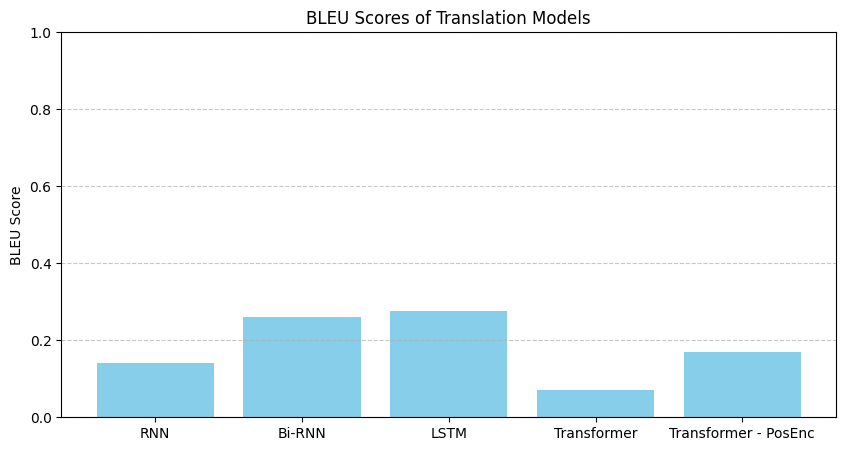

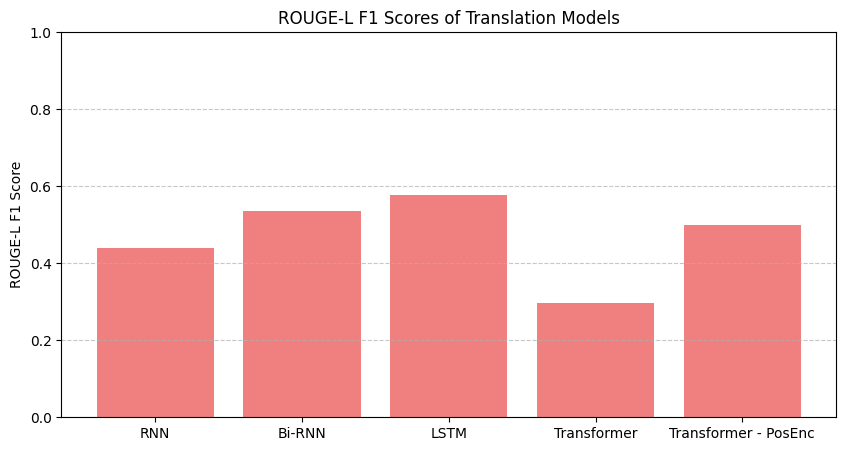

In [ ]:
import matplotlib.pyplot as plt

model_names = ["RNN", "Bi-RNN", "LSTM", "Transformer", "Transformer - PosEnc"]

bleu_scores = [
    rnn_bleu,
    bilstm_bleu,
    lstm_bleu,
    transformer_bleu,
    transformer_bleu_nopos
]

rouge_scores = [
    rnn_rouge["rouge-l"],
    bilstm_rouge["rouge-l"],
    lstm_rouge["rouge-l"],
    transformer_rouge["rouge-l"],
    transformer_rouge_nopos["rouge-l"]
]

plt.figure(figsize=(10, 5))
plt.bar(model_names, bleu_scores, color='skyblue')
plt.title("BLEU Scores of Translation Models")
plt.ylabel("BLEU Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(model_names, rouge_scores, color='lightcoral')
plt.title("ROUGE-L F1 Scores of Translation Models")
plt.ylabel("ROUGE-L F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Testing

In [ ]:
rnn_model=load_model('./data/models/RNN_seq2seq.keras')
RNN_Bi_model=load_model('./data/models/RNN_bi_seq2seq.keras')
lstm_model=load_model('./data/models/LSTM_seq2seq.keras')
Transformer_model=load_model('./data/models/RNN_seq2seq.keras')
glove_model=load_model('./data/models/glove_model.keras')

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=13b7278ad8ad40b5a17ff5decb14e2fa590cd6aa8215de711346108c7c7ae3c7
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


# Testing

In [ ]:
max_english_length=max_length_english
max_urdu_length=max_length_urdu

In [ ]:
import numpy as np

def translate_user_prompt(input_sentence: str,
                          model,
                          english_tokenizer: Tokenizer,
                          urdu_tokenizer: Tokenizer,
                          max_length_english: int,
                          max_length_urdu: int) -> str:
  
    input_sentence_with_tokens = f"<start> {input_sentence} <end>"
    tokenized_sentence = english_tokenizer.texts_to_sequences([input_sentence_with_tokens])
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=max_length_english, padding='post', truncating='post')

    start_token_index = urdu_tokenizer.word_index['<start>']
    decoder_input = np.zeros((1, max_length_urdu - 1))  
    decoder_input[0, 0] = start_token_index

    translated_sentence = []
    for i in range(max_length_urdu - 1):
        predictions = model.predict([padded_sentence, decoder_input], verbose=0)

        predicted_word_index = np.argmax(predictions[0, i, :])

        if predicted_word_index == urdu_tokenizer.word_index['<end>']:
            break

        translated_sentence.append(predicted_word_index)

        if i + 1 < (max_length_urdu - 1):
            decoder_input[0, i + 1] = predicted_word_index

    index_to_word = {id: word for word, id in urdu_tokenizer.word_index.items()}
    index_to_word[0] = '<PAD>'  

    decoded_translation = ' '.join([index_to_word[idx] for idx in translated_sentence
                                    if idx not in [0, urdu_tokenizer.word_index['<start>'], urdu_tokenizer.word_index['<end>']]])

    return decoded_translation.strip()

models = {
    'RNN': rnn_model,
    'Bi-RNN': RNN_Bi_model,
    'LSTM': lstm_model,
    'Transformer': Transformer_model,
    'RNN (GloVe)': glove_model
}

user_input = "This is a book"

for name, model in models.items():
    translation = translate_user_prompt(
        input_sentence=user_input,
        model=model,
        english_tokenizer=english_tokenizer,
        urdu_tokenizer=urdu_tokenizer,
        max_length_english=max_english_length,  # e.g., 38 (with tokens)
        max_length_urdu=max_urdu_length        # e.g., 38 (with tokens)
    )
    print(f"\nModel: {name}")
    print(f"Input: {user_input}")
    print(f"Translation: {translation}")


Model: RNN
Input: This is a book
Translation: زین نے مجھے دیکھا

Model: Bi-RNN
Input: This is a book
Translation: یہ ایک چوہا تھا

Model: LSTM
Input: This is a book
Translation: یہ کتاب ایک ہے

Model: Transformer
Input: This is a book
Translation: 

Model: RNN (GloVe)
Input: This is a book
Translation: میں نے اسے ایک ملازمت کو دیکھا ہے
